# Ground heat flux at the surface ($G$)

$$
C_{soil} \frac{\partial T_{s}}{\partial t} = (1-\alpha) \cdot SW_d + LW_d - LW_u \ - H - \lambda E - \textcolor{red}{G}      \tag{1.2}
$$

- **Definition:** The rate of heat transfer per unit area by turbulence between land surface and soil.

- **Equation:**

$$
G = - K_g \frac {\partial T_g(z)}{\partial z}  \tag{8.1}
$$

where $K_g$ is the thermal moecular condunctivity, and $T_g(z)$ is the soil temperature at depth of $z$. Additionally, $T_g(k)$ refers $T_g$ at $k$<sup>th</sup> soil layer in the LSM. Through out this lecture, we assume $T_g(k=1)$ is equal to $T_s$.

<br>
<br>
<br>
<hr>

### Multi soil layer LSM

- So far, the LSM we built is One soil layer LSM with fixed $G$.
- Let's introduce multi (in this lecture, two) soil layer concept into our LSM.


<figure>
  <img src="../_static/images/ground_heat_flux_01.png" alt="Diagram of two soil layer LSM">
  <figcaption>Figure 8.1. Diagram of two soil layer LSM.</figcaption>
</figure>

<br>
<br>
<hr>

##### Ground heat flux at each soil layer

- Ground heat flux between 1st and 2nd soil layers:

$$
G_{1-2} = - K_g \frac {T_g(k=2) - T_s}{\Delta z_{1-2}}      \tag{8.2}
$$

where $G_{1-2}$ is $G$ between 1st and 2nd soil layers, $\Delta z_{1-2}$ is the thickness of the 1st soil layer.

<br>

- Ground heat flux between 2st and deep soil layer (fixed usually):

$$
G_{2-3} = - K_g \frac {T_g(k=3) - T_g(k=2)}{\Delta z_{2-3}}      \tag{8.3}
$$

where $G_{2-3}$ is $G$ between 2nd and deeper soil layers, $\Delta z_{2-3}$ is the thickness of the 2nd soil layer.

<br>
<br>
<hr>

##### Soil temperature

$$
C_{soil,1-2} \frac{\partial T_{s}}{\partial t} = (1-\alpha) \cdot SW_d + LW_d - LW_u \ - H - \lambda E + \textcolor{red}{K_g \frac {T_g(k=2) - T_s}{\Delta z_{1-2}}}      \tag{8.4}
$$

<br>

$$
C_{soil,2-3} \frac{\partial T_{g}(k=2)}{\partial t} = \textcolor{red}{- K_g \frac {T_g(k=2) - T_s}{\Delta z_{1-2}}} + \textcolor{green}{K_g \frac {T_g(k=3) - T_g(k=2)}{\Delta z_{2-3}}}      \tag{8.5}
$$

where $C_{soil,1-2}$ and $C_{soil,2-3}$ are soil heat capacity per unit crea.

<br>
<br>
<br>
<hr>

### Practice 8.1

Predict $T_s$ and $T_g$ at Daegu ASOS station in April 2012 using observed atmospheric variables with Eqs. 8.2-5. Assume that

1) Observed variables contain $T_a$, $U$, & $SW_d$.
1) $z_r$ is 20 m
1) $z_0$ is 0.15 m
1) $T_s$ at initial time is set to observed $T_s$
1) $T_g(k=2)$ is initialized with $T_s-$ 0.2 K
1) $T_g(k=3)$ is fixed at $T_s-$ 0.5 K
1) $K_g$ is 1.0 W/m<sup>2</sup>/K
1) $C_{soil,1-2}$ and $C_{soil,2-3}$ are $c_{soil} \cdot \Delta z_{1-2}$ and $c_{soil} \cdot \Delta z_{2-3}$ ($c_s$ = 2.0 $\times$ 10<sup>6</sup> J/m<sup>3</sup>/K, $\Delta z_{1-2}$ is 0.07 m, and $\Delta z_{2-3}$ is 0.35 m
1) $\alpha$ is 0.3
1) $LW_d$ is 400 W/m<sup>2</sub>
1) $theta$ is 0.2 m<sup>3</sub>/m<sup>3</sub>


&#8594; Predict $\textcolor{red}{T_s}$, $\textcolor{red}{LW_u}$, $\textcolor{red}{H}$, $\textcolor{red}{\lambda E}$, $\textcolor{red}{G}$ by prescribing $SW_d$, $LW_d$:

$$
C_{soil} \textcolor{red}{\frac{\partial T_{s}}{\partial t}} = (1-\alpha) \cdot SW_d + LW_d - \textcolor{red}{LW_u} - \textcolor{red}{H} - \textcolor{red}{\lambda E} - \textcolor{red}{G}       \tag{1.1}
$$


In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import function_package as fp

In [6]:
# Setup

dt = 60 # s

# Make assumptions
LWd = 400   # W/m2
zr = 20.0   # height of the model lowest layer [m]
z0 = 0.15   # roughness length [m]

KG = 1.0    # W/m2/K

Z_12 = 0.07                       # m
Z_23 = 0.35                       # m
C_SOIL_1_2 = 2.0 * 1.0e6 * Z_12   # J/m2/K
C_SOIL_2_3 = 2.0 * 1.0e6 * Z_23   # J/m2/K

theta = 0.2   # m3/m3

In [5]:
# Get observation data

Ta, Ts, Pa, Qa, wind_speed, SWd, rho, R, ASOS_Daegu = fp.read_ASOS_at_Daegu('../data/ASOS_processed_2012033100-2012050200.nc', time_interval='1min')

In [7]:
# Predict Ts

time_dimension_size = len(Ts)

### Create an array for Ts
predicted_Ts  = np.zeros(time_dimension_size)
predicted_Tg2 = np.zeros(time_dimension_size)
predicted_Tg3 = np.zeros(time_dimension_size)
predicted_ust = np.zeros(time_dimension_size)
predicted_rh  = np.zeros(time_dimension_size)
predicted_H   = np.zeros(time_dimension_size)
predicted_LE  = np.zeros(time_dimension_size)
predicted_G12 = np.zeros(time_dimension_size)
predicted_G23 = np.zeros(time_dimension_size)
predicted_q_sat = np.zeros(time_dimension_size)

### Initial value of Ts, Tg
predicted_Ts[0]  = Ts.isel(time=0).values
predicted_Tg2[0] = predicted_Ts[0] - 0.2
predicted_Tg3[:] = predicted_Ts[0] - 0.5


from tqdm import tqdm
for n in tqdm(np.arange(1, time_dimension_size), desc='Predicting surface temperature'):

    ### ①
    Rib = fp.calculate_bulk_richardson_number(predicted_Ts[n-1], Ta[n-1], Pa[n-1], wind_speed[n-1], zr)

    ### ②
    if Rib == 0.0:
        z_over_L = 0.0
    else:
        z_over_L = fp.calculate_z_over_L(Rib, zr, z0)

    ### ③
    z0_over_L  = z_over_L / zr * z0
    
    if Rib == 0.0:     # Neutral
        psi_m = 0.0
        psi_h = 0.0
    
    elif Rib > 0:      # Stable
        psi_m = fp.calculate_psim_stable(z_over_L) - fp.calculate_psim_stable(z0_over_L)
        psi_h = fp.calculate_psih_stable(z_over_L) - fp.calculate_psih_stable(z0_over_L)
    
    elif Rib < 0:      # Unstable
        psi_m = fp.calculate_psim_unstable(z_over_L) - fp.calculate_psim_unstable(z0_over_L)
        psi_h = fp.calculate_psih_unstable(z_over_L) - fp.calculate_psih_unstable(z0_over_L)

    ### ④
    zr_over_z0 = zr / z0
    ust = fp.KARMAN * wind_speed[n-1] / (np.log(zr_over_z0) - psi_m)
    predicted_ust[n] = ust

    ### ⑤
    rh = 1/(fp.KARMAN * ust) * ( np.log(zr_over_z0) - psi_h )
    predicted_rh[n] = rh

    ### ⑥
    H = rho[n-1] * fp.C_P * (predicted_Ts[n-1] - Ta[n-1]) / rh
    predicted_H[n] = H

    ### Latent heat flux
    predicted_q_sat[n]  = fp.calculate_q_sat(predicted_Ts[n-1], fp.P_SFC)
    beta      = fp.calculate_moisture_availability(theta, Qa[n-1], predicted_q_sat[n])
    LE        = rho[n-1] * fp.LV * (beta*predicted_q_sat[n] - Qa[n-1]) / rh
    predicted_LE[n] = LE

    ### Ground heat flux
    G12 = KG * (predicted_Ts[n-1] - predicted_Tg2[n-1])  / Z_12
    predicted_G12[n] = G12
    G23 = KG * (predicted_Tg2[n-1] - predicted_Tg3[n-1]) / Z_23
    predicted_G23[n] = G23

    ### Upward longwave radiation
    LWu = fp.calculate_LWu(predicted_Ts[n-1])

    ### Surface & soil temperature
    predicted_Ts[n]  = predicted_Ts[n-1]  + dt/fp.C_SOIL_1_2 * ( (1-fp.ALBEDO) * SWd[n-1] + LWd - LWu - H - LE - G12 )
    predicted_Tg2[n] = predicted_Tg2[n-1] + dt/fp.C_SOIL_2_3 * ( G12 - G23 )


predicted_Ts = xr.DataArray(predicted_Ts, dims='time', coords={'time': Ts['time'].values},
                 attrs={'units': 'K',
                        'long_name': 'Predicted surface temperature'},)
predicted_Ts

Predicting surface temperature: 100%|██████████| 5760/5760 [02:09<00:00, 44.40it/s]


<xarray.DataArray (time: 5761)> Size: 46kB
array([277.93      , 277.95760692, 277.98404208, ..., 286.26403219,
       286.25676483, 286.24955147], shape=(5761,))
Coordinates:
  * time     (time) datetime64[ns] 46kB 2012-04-01 ... 2012-04-05
Attributes:
    units:      K
    long_name:  Predicted surface temperature

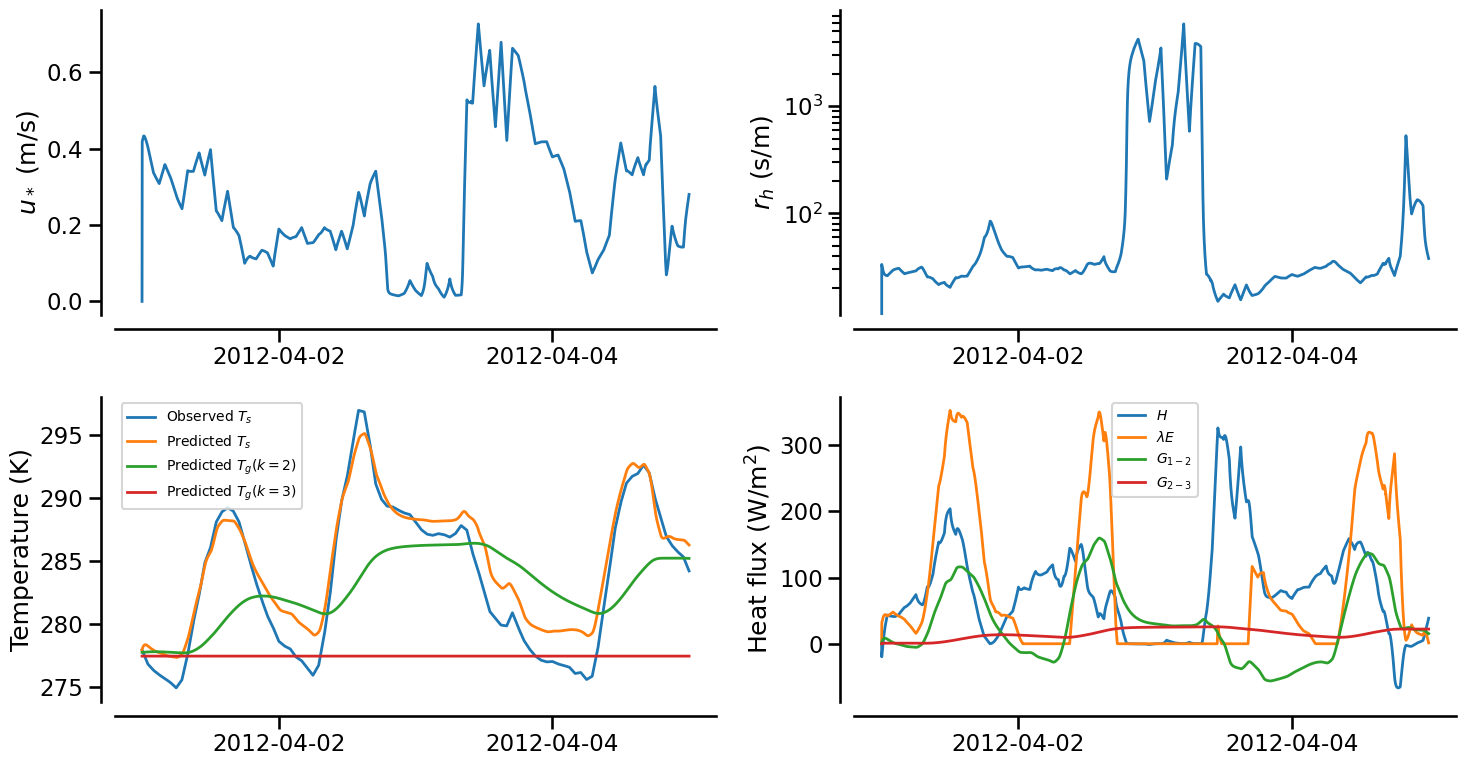

In [8]:
# plot

import matplotlib.dates as mdates

sns.set_context('talk')
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 8))

time_info = Ts['time'].values

### Friction velocity
ax[0,0].plot(time_info, predicted_ust, linewidth=2)
ax[0,0].set_ylabel('$u_*$ (m/s)', fontsize=18)

### Aerodynamic resistance
ax[0,1].plot(time_info, predicted_rh, linewidth=2)
ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('$r_h$ (s/m)', fontsize=18)

### Surface temperature
ax[1,0].plot(time_info, Ts,           linewidth=2, c='C0', label='Observed $T_s$')
ax[1,0].plot(time_info, predicted_Ts, linewidth=2, c='C1', label='Predicted $T_s$')
ax[1,0].plot(time_info, predicted_Tg2,linewidth=2, c='C2', label='Predicted $T_g(k=2)$')
ax[1,0].plot(time_info, predicted_Tg3,linewidth=2, c='C3', label='Predicted $T_g(k=3)$')
ax[1,0].set_ylabel('Temperature (K)', fontsize=18)
ax[1,0].legend(fontsize=10)

### Heat flux
ax[1,1].plot(time_info, predicted_H,  linewidth=2,  c='C0', label=r'$H$')
ax[1,1].plot(time_info, predicted_LE, linewidth=2,  c='C1', label=r'$\lambda E$')
ax[1,1].plot(time_info, predicted_G12, linewidth=2, c='C2', label=r'$G_{1-2}$')
ax[1,1].plot(time_info, predicted_G23, linewidth=2, c='C3', label=r'$G_{2-3}$')
ax[1,1].set_ylabel('Heat flux (W/m$^2$)', fontsize=18)
ax[1,1].legend(fontsize=10)

### properties
for i in range(2):
    for j in range(2):
        ax[i,j].xaxis.set_major_locator(mdates.DayLocator(interval=2))

sns.despine(offset=10)
plt.tight_layout()